<a href="https://colab.research.google.com/github/keirace/artificial-guacamole/blob/master/ocr/ocr_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import PIL, os, cv2, shutil, glob
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from keras import Input
from keras.models import Model, Sequential
from keras.constraints import maxnorm
from tensorflow.keras import layers

In [ ]:
!pip install tf-nightly-gpu

     |████████████████████████████████| 392.0MB 43kB/s 
     |████████████████████████████████| 10.6MB 16.3MB/s 
     |████████████████████████████████| 471kB 46.4MB/s 


# **Preprocessing images and labels**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
# Path to the data directory
data_dir = Path("/content/drive/My Drive/ฝึกงาน/labeled")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*/*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 50
img_height = 40

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  215
Number of labels found:  215
Number of unique characters:  11
Characters present:  {'7', '3', '2', '0', '4', '1', '6', '8', '9', '.', '5'}


In [ ]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [ ]:
test_dir = Path('/content/drive/My Drive/ฝึกงาน/test')
images = sorted(list(map(str, list(test_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
test_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
for label in labels:
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Data visualization

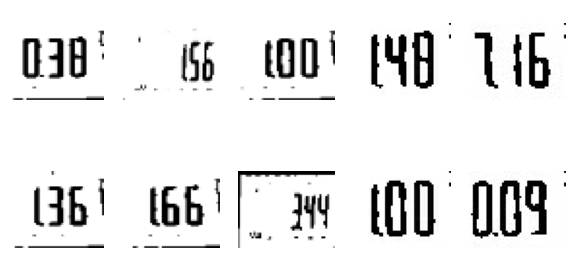

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(10):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 5, i % 5].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 5, i % 5].set_title(label, color='white')
        ax[i // 5, i % 5].axis("off")
plt.show()

# Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        # input_length = layers.Input((1,), name='input_length')
        # label_length = layers.Input((1,), name='label_length')
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return loss


def build_model():
    # Inputs to the model
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", 
                             dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",name="Conv1",
        kernel_initializer="he_normal",padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3), activation="relu",name="Conv2",
        kernel_initializer="he_normal",padding="same")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters)+1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    # ctc = CTCLayer(name="ctc_loss")
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 40, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 50, 40, 32)   320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 25, 20, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 25, 20, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

# Datagen

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    validation_split = 0.2
    # rotation_range=15,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    )
# datagen.fit(X_train)

In [ ]:
aug = '/content/drive/My Drive/ฝึกงาน/num_aug'

train_datagen = datagen.flow_from_directory(aug, target_size=(32,16),
                                            batch_size=16, classes=num,
                                            subset='training')
val_datagen = datagen.flow_from_directory(aug, target_size=(32,16), 
                                          batch_size=16,
                                          subset='validation', classes=num)

# Train

In [ ]:
epochs = 100
early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(train_dataset, validation_data=validation_dataset,
    epochs=epochs, callbacks=[early_stopping],
)

Epoch 1/100
13/13 [==============================] - 55s 4s/step - loss: 13.5237 - val_loss: 10.3188
Epoch 2/100
13/13 [==============================] - 1s 96ms/step - loss: 9.6096 - val_loss: 9.9553
Epoch 3/100
13/13 [==============================] - 1s 98ms/step - loss: 9.2524 - val_loss: 9.5184
Epoch 4/100
13/13 [==============================] - 1s 94ms/step - loss: 8.9503 - val_loss: 9.0314
Epoch 5/100
13/13 [==============================] - 1s 98ms/step - loss: 8.6334 - val_loss: 8.6467
Epoch 6/100
13/13 [==============================] - 1s 96ms/step - loss: 8.3361 - val_loss: 8.2596
Epoch 7/100
13/13 [==============================] - 1s 92ms/step - loss: 8.0955 - val_loss: 7.9253
Epoch 8/100
13/13 [==============================] - 1s 99ms/step - loss: 7.8054 - val_loss: 7.6369
Epoch 9/100
13/13 [==============================] - 1s 95ms/step - loss: 7.4533 - val_loss: 7.3663
Epoch 10/100
13/13 [==============================] - 1s 96ms/step - loss: 7.3066 - val_loss: 7.028

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 50, 40, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 50, 40, 32)        320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 25, 20, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 25, 20, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 12, 10, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 640)           0         
_________________________________________________________________
dense1 (Dense)               (None, 12, 64)            41024 

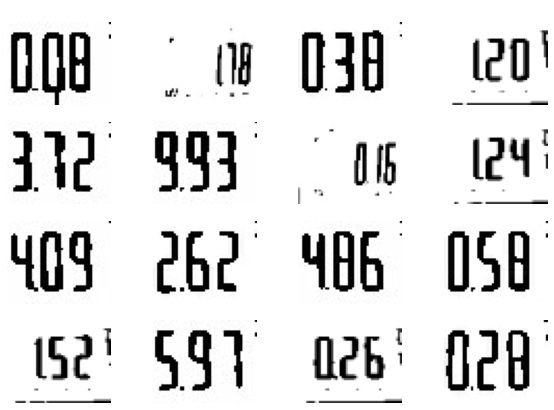

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(10, 7))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title, color='white')
        ax[i // 4, i % 4].axis("off")
plt.show()

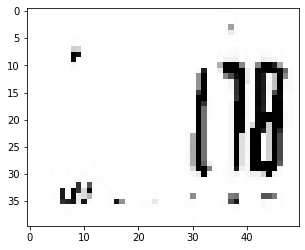

In [ ]:
o = (batch_images[1,:,:,0]*255).numpy().astype(np.uint8)
o = o.T
model.predict()
plt.imshow(o, cmap='gray')

In [ ]:
prediction_model.save('/content/drive/My Drive/ฝึกงาน/ocrNewModel_prediction')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2293: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1388: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: /content/drive/My Drive/ฝึกงาน/ocrNewModel_prediction/assets


TypeError: ignored

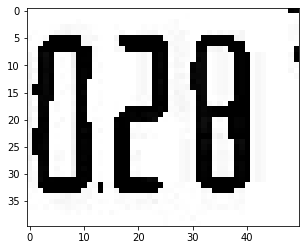

In [ ]:
img = tf.io.read_file('/content/drive/My Drive/ฝึกงาน/frames/265.jpg')
# 2. Decode and convert to grayscale
img = tf.io.decode_jpeg(img, channels=1)
# 3. Convert to float32 in [0, 1] range
img = tf.image.convert_image_dtype(img, tf.float32)
# 4. Resize to the desired size
img = tf.image.resize(img, [img_height, img_width])
# 5. Transpose the image because we want the time
# dimension to correspond to the width of the image.
img = tf.transpose(img, perm=[1, 0, 2])
vis = (img[:, :, 0] * 255).numpy().astype(np.uint8)
plt.imshow(vis.T, cmap='gray')
preds = prediction_model.predict(np.expand_dims(img,0))
# pred_texts = decode_batch_predictions(preds)
# print(pred_texts)

input_len = np.ones(preds.shape[0]) * preds.shape[1]
# Use greedy search. For complex tasks, you can use beam search
results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_length]
output_text = []
a = results[0]
output = []
for n in a:
  output.append(Class[n])
tf.strings.reduce_join(output).numpy().decode("utf-8")

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

TensorShape([16, 50, 40, 1])

In [ ]:
test = keras.models.load_model('/content/drive/My Drive/ฝึกงาน/ocrNewModel')

In [ ]:
pre = keras.models.load_model('/content/drive/My Drive/ฝึกงาน/ocrNewModel_prediction')

In [ ]:
pre = keras.models.Model(
    test.get_layer(name="image").input, test.get_layer(name="dense2").output
)